In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from ipywidgets import interact, interactive, fixed

%matplotlib inline

failed to find corner on: ./camera_cal/calibration1.jpg
failed to find corner on: ./camera_cal/calibration4.jpg
failed to find corner on: ./camera_cal/calibration5.jpg


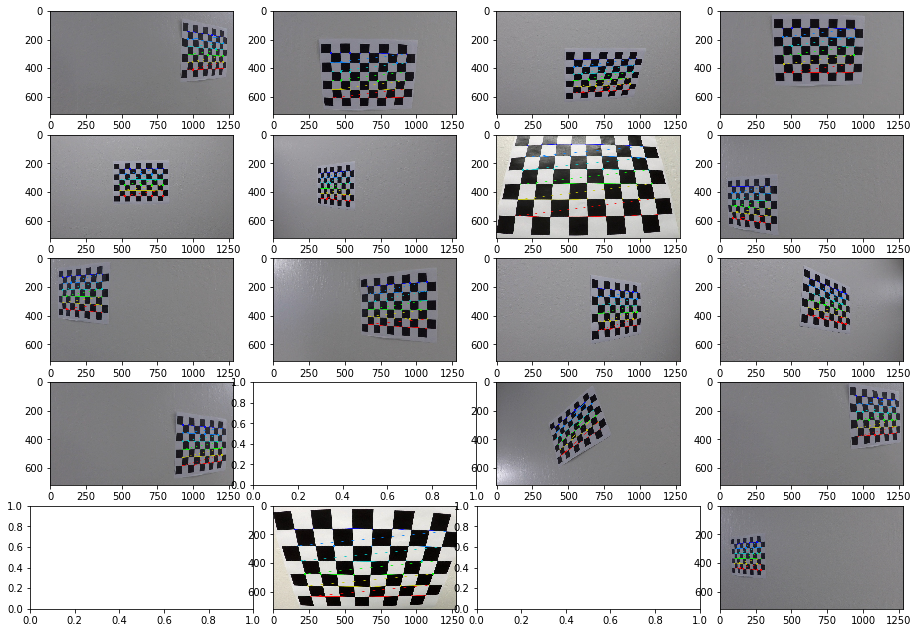

In [2]:
#Step 1. Calibrate camera
#1.1 find chessboard corners and get the calibration matrix
import glob
camera_cals = glob.glob("./camera_cal/*.jpg")
nx=9
ny=6

objpoints = []
imgpoints = []
objp = np.zeros((nx*ny,3), np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)# initialize x, y coordinates to grid, z to zero
calibration_imgs = []

fig, axs = plt.subplots(5,4, figsize=(16, 11))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

w = h = 0
for i, imgf in enumerate(camera_cals):
    img =mpimg.imread(imgf) 
    calibration_imgs.append(img)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    h, w = gray.shape
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    if not ret:
        print("failed to find corner on:", imgf)
    else:    
        imgpoints.append(corners)
        objpoints.append(objp)
        img_t = img.copy()
        img_t = cv2.drawChessboardCorners(img_t, (nx,ny), corners, ret)
        axs[i].imshow(img_t)
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, (w, h), None, None)

Failed in finding corners for 3 images with given number of chessboard corners so they don't appear here.

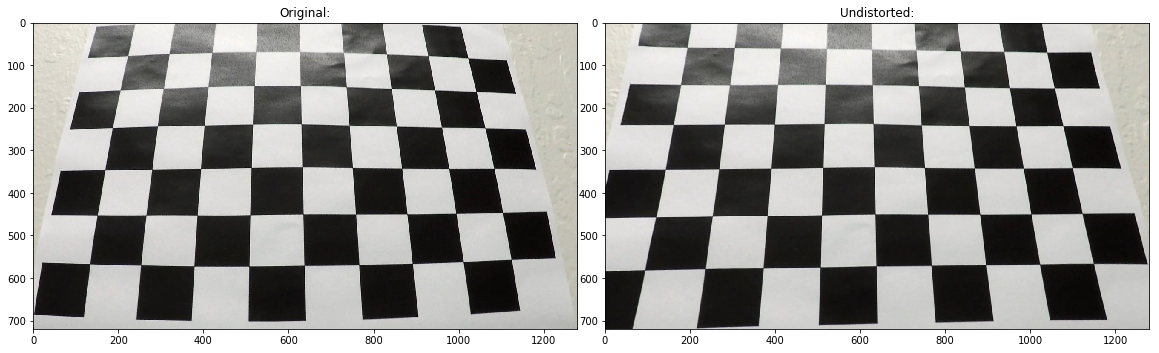

In [3]:
#Check distort correction with one of calibration images
img = calibration_imgs[6]
undst = cv2.undistort(img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax1.set_title('Original:')
ax2.imshow(undst)
ax2.set_title('Undistorted:')

In [290]:
#load test images
#tests = sorted(glob.glob("./test_images/*.jpg"))
tests = sorted(glob.glob("./challenge/*.jpg"))
n = len(tests)
test_imgs = []
w = h = 0
for i, imgf in enumerate(tests):
    img = cv2.imread(imgf)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    w,h = img.shape[1::-1]
    test_imgs.append(img)
    print (i, imgf)

0 ./challenge/0.jpg
1 ./challenge/1.jpg
2 ./challenge/13.jpg
3 ./challenge/16.jpg
4 ./challenge/4.jpg


In [150]:
#Create a debugger class for holding debug info in later stages
class Debugger:
    def __init__(self):
        self.messages = []
dbg = Debugger()    

In [163]:
#Use straight lane images to select the source/destination points.

#src = np.float32([[622,460],[690,460],[1120,720],[295,720]])

src = np.float32([[605,480],[720,480],[1120,720],[295,720]])

ROI = np.float32([[560,440],[725,440],[1130,720],[180,720]])
offset = 300
dst = np.float32([[offset, 150], [1280-offset,150], [1280-offset, 720],[offset, 720]])

M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)
def unwarp(img):
    unwarped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return unwarped
def crop(img, left, right):
    img[:,0:left] = [0,0,0]
    img[:,right:] = [0,0,0]
    return img

Next step is to do a perspective transform

[  605.   720.  1120.   295.   605.] [ 480.  480.  720.  720.  480.]


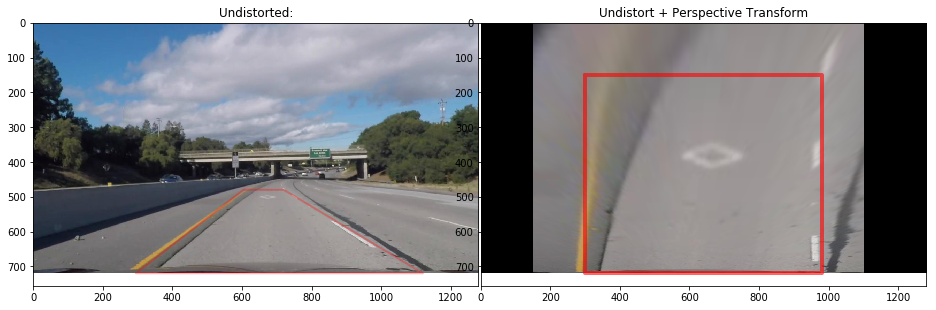

In [165]:
img = test_imgs[1].copy()
undist = undistort(img)
#do the perspective transform on an undistorted image
warped = unwarp(undist)
warped = crop(warped, 150, 1100)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,8))
f.subplots_adjust(hspace = .2, wspace=.005)
ax1.imshow(undist)
#overlay the source points trapezoid
x = src[:,0]
y = src[:,1]
x = np.append(x, src[0][0])
y = np.append(y, src[0][1])
ax1.plot(x, y, color='red', alpha=0.3, linewidth=2, solid_capstyle='round', zorder=2)
print (x, y)
#ax1.set_ylim([h,0])
#ax1.set_xlim([0,w])
ax1.set_title('Undistorted:')

ax2.imshow(warped)
#overlay the destination points rectangle 
x = dst[:,0]
y = dst[:,1]
x = np.append(x, dst[0][0])
y = np.append(y, dst[0][1])
ax2.plot(x, y, color='red', alpha=0.6, linewidth=4, solid_capstyle='round', zorder=2)
ax2.set_title('Undistort + Perspective Transform')


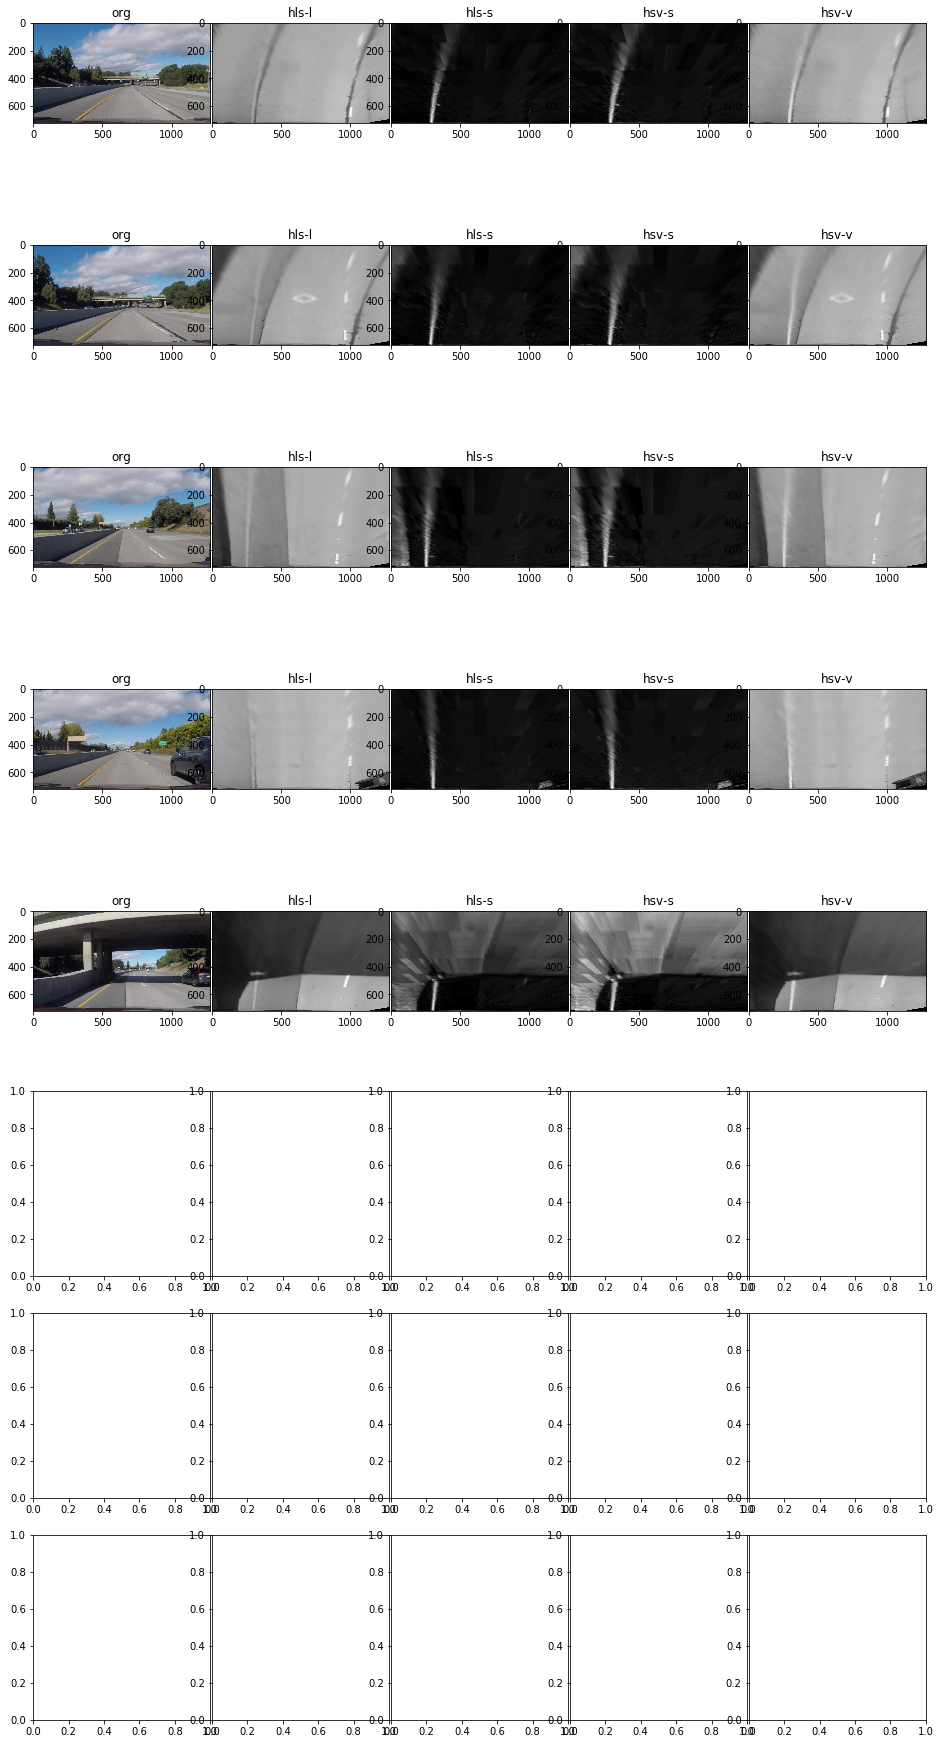

In [291]:
f, axs = plt.subplots(8, 5, figsize=(16,32))
f.subplots_adjust(hspace =.2, wspace=.01)
axs = axs.ravel()

for i,img in enumerate(test_imgs):
    warped = unwarp(undistort(img))
    hls_l = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)[:,:,1]
    hls_s = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)[:,:,2]
    hsv_s = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)[:,:,1]
    hsv_v = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)[:,:,2]
    
    axs[5*i].imshow(img)
    axs[5*i].set_title('org')
    axs[5*i+1].imshow(hls_l, cmap='gray')
    axs[5*i+1].set_title('hls-l')
    axs[5*i+2].imshow(hls_s,cmap='gray')
    axs[5*i+2].set_title('hls-s')
    axs[5*i+3].imshow(hsv_s,cmap='gray')
    axs[5*i+3].set_title('hsv-s')
    axs[5*i+4].imshow(hsv_v,cmap='gray')
    axs[5*i+4].set_title('hsv-v')

both HSV V channel (HSV:V) and HLS S channel(HLS:S) can caputre the wihte and yellow lines and seperate them out of background well. 

In [114]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # If img is in RGB format, Convert to grayscale
    if len(img.shape) > 2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        gray = img
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y'))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output


<function __main__.update>

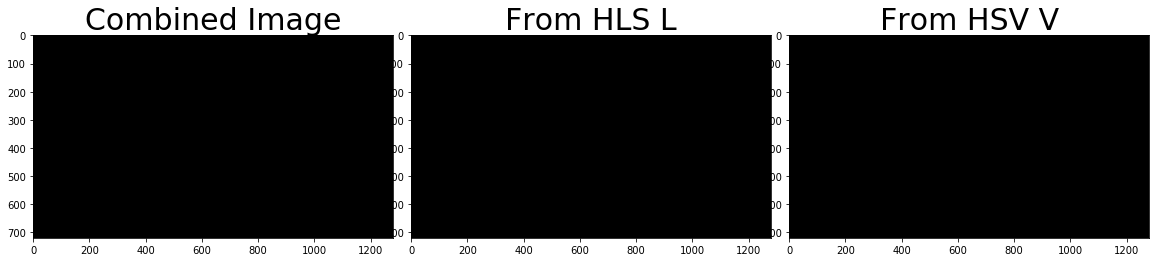

In [115]:
def update(n, thresh_min_hls, thresh_max_hls, thresh_min_hsv, thresh_max_hsv):
    #hls_s = cv2.cvtColor(unwarp(undistort(test_imgs[n])), cv2.COLOR_RGB2HLS)[:,:,2]
    #hsv_v = cv2.cvtColor(unwarp(undistort(test_imgs[n])), cv2.COLOR_RGB2HSV)[:,:,2]
    hls_s = cv2.cvtColor((undistort(test_imgs[n])), cv2.COLOR_RGB2HLS)[:,:,2]
    hsv_v = cv2.cvtColor((undistort(test_imgs[n])), cv2.COLOR_RGB2HSV)[:,:,2]
    img0 = abs_sobel_thresh(hls_s, 'x',thresh_min_hls, thresh_max_hls)
    img1 = abs_sobel_thresh(hsv_v, 'x',thresh_min_hsv, thresh_max_hsv)
    img0 = unwarp(img0)
    img1 = unwarp(img1)
    combined = np.zeros_like(img0)
    combined[((img0 == 1) | (img1 == 1))] = 1
    #combined = unwarp(img1)
    
    # Visualize sobel direction threshold
    f, axs = plt.subplots(1, 3, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    axs = axs.ravel()
    axs[0].imshow(combined, cmap='gray')
    axs[0].set_title('Combined Image', fontsize=30)
    axs[1].imshow(img0, cmap='gray')
    axs[1].set_title('From HLS L', fontsize=30)
    axs[2].imshow(img1, cmap='gray')
    axs[2].set_title('From HSV V', fontsize=30)

interact(update, 
         n=(0,len(test_imgs)-1),
         thresh_min_hls=(0,255),
         thresh_max_hls=(0,255),
         thresh_min_hsv=(0,255),
         thresh_max_hsv=(0,255)
        )
#HLS:16-127, HSV:8-127

The Sobel on HLS:S channel gives the best result for this image.

In [116]:
def mag_thresh(img, sobel_kernel=3, mag_thresh_min=0, mag_thresh_max=255):
    # Convert to grayscale
    gray = img
    if len(img.shape)>2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,2]
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh_min) & (gradmag <= mag_thresh_max)] = 1

    # Return the binary image
    return binary_output

In [117]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_thresh(img, sobel_kernel=3, dir_thresh_min=0, dir_thresh_max=np.pi/2):
    # Grayscale
    gray = img
    if len(img.shape)>2:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,2]
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh_min) & (absgraddir <= dir_thresh_max)] = 1

    # Return the binary image
    return binary_output

<function __main__.update>

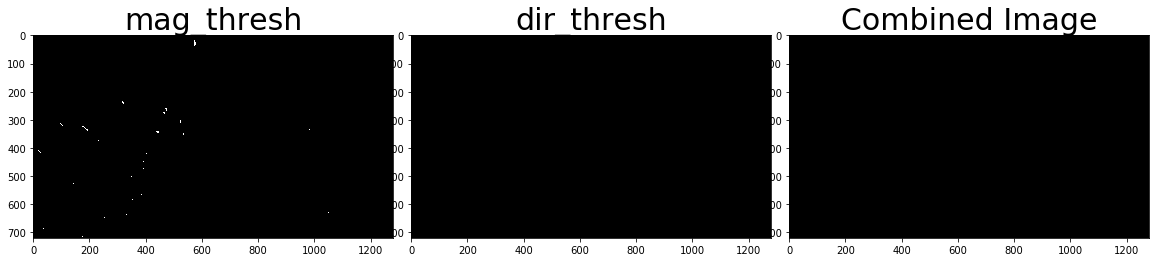

In [118]:
def update(n, kernel_size, dir_thresh_min, dir_thresh_max,mag_thresh_min, mag_thresh_max):
    hls_s = cv2.cvtColor(undistort(test_imgs[n]), cv2.COLOR_RGB2HLS)
    #img0 = mag_thresh(hls_s, kernel_size,mag_thresh_min, mag_thresh_max)
    img0 = abs_sobel_thresh(hls_s, 'x',mag_thresh_min, mag_thresh_max)
    img1 = dir_thresh(hls_s, kernel_size,dir_thresh_min, dir_thresh_max)
    img0 = unwarp(img0)
    img1 = unwarp(img1)
    
    combined = np.zeros_like(img0)
    combined[(img0 == 1) & (img1 == 1)] = 1
    #combined = unwarp(combined)
    # Visualize sobel direction threshold
    
    f, axs = plt.subplots(1, 3, figsize=(20,10))
    f.subplots_adjust(hspace = .2, wspace=.05)
    axs = axs.ravel()
    axs[0].imshow(img0, cmap='gray')
    axs[0].set_title('mag_thresh', fontsize=30)
    axs[1].imshow(img1, cmap='gray')
    axs[1].set_title('dir_thresh', fontsize=30)
    axs[2].imshow(combined, cmap='gray')
    axs[2].set_title('Combined Image', fontsize=30)

interact(update, 
         n = (0,len(test_imgs)-1),
         kernel_size=(1,31,2),
         mag_thresh_min=(0,255),
         mag_thresh_max=(0,255),
         dir_thresh_min=(0,np.pi/2, 0.01),
         dir_thresh_max=(0,np.pi/2, 0.01)
        )
#k:3, dir:0.80-1.31, mag:15-150

In [236]:
def hsv_v_thresh(img, thresh=(170, 255)):
    # convert to hsv space and extract v channel
    ch = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,2]
    ch = ch*(255//np.max(ch))
    _, out = cv2.threshold(ch,thresh[0],thresh[1],cv2.THRESH_TOZERO)
    return out


<function __main__.update>

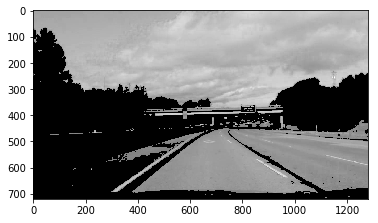

In [237]:
def update(n, tl, th):
    img = hsv_v_thresh(test_imgs[n],(tl,th))
    plt.imshow(img, 'gray')
    
interact(update, 
         n = (0,len(test_imgs)-1),
         tl = (0,255),
         th = (0,255)
        )

In [1]:
def hsv_v_thresh(img, thresh=(255, 11)):
    # convert to hsv space and extract v channel
    ch = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)[:,:,2]
    #ch = ch*(255//np.max(ch))
    #_, out = cv2.threshold(ch,thresh[0],thresh[1],cv2.THRESH_TOZERO)
    #_, out = cv2.threshold(out,thresh[1],0,cv2.THRESH_TOZERO_INV)
    out = cv2.adaptiveThreshold(ch,thresh[0],cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY_INV,11,thresh[1])
    
    return out
def update(n, tl, th,ml,mh):
    img = hsv_v_thresh(test_imgs[n],(tl,th))
    ret,img = cv2.threshold(img,ml,mh,cv2.THRESH_BINARY)
    #img = abs_sobel_thresh(img, 'x',ml, mh)
    #img = mag_thresh(img, 7,ml, mh)
    plt.imshow(img, 'gray')
    
interact(update, 
         n = (0,len(test_imgs)-1),
         tl = (0,255),
         th = (0,255),
         ml = (0,255),
         mh = (0,255)
        )

NameError: name 'interact' is not defined

In [238]:
#undistort->to HLS and HSV, sobel_x->combine->unwarp
def crop(img, left, right):
    img[:,0:left] = 0
    img[:,right:] = 0
    return img
def image_pipeline(img):
    img  = undistort(img)
    undist = img.copy()
    img = crop(img, 150, 1100)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_s = hls[:,:,2] #S
    #hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    #hsv_v = hsv[:,:,2] #V
    hsv_v = hsv_v_thresh(img)
    
    img0 = abs_sobel_thresh(hsv_v, 'x',8, 127)
    img0 = unwarp(img0)
    img0 = crop(img0, 150, 1100)
    img1 = dir_thresh(hsv_v, 7, 0.70, 1.33)
    img1 = unwarp(img1)
    img1 = crop(img1, 150, 1100)
    combined = np.zeros_like(img0)
    combined[(img0 == 1) & (img1 == 1)] = 1
    return combined, undist, img0, img1

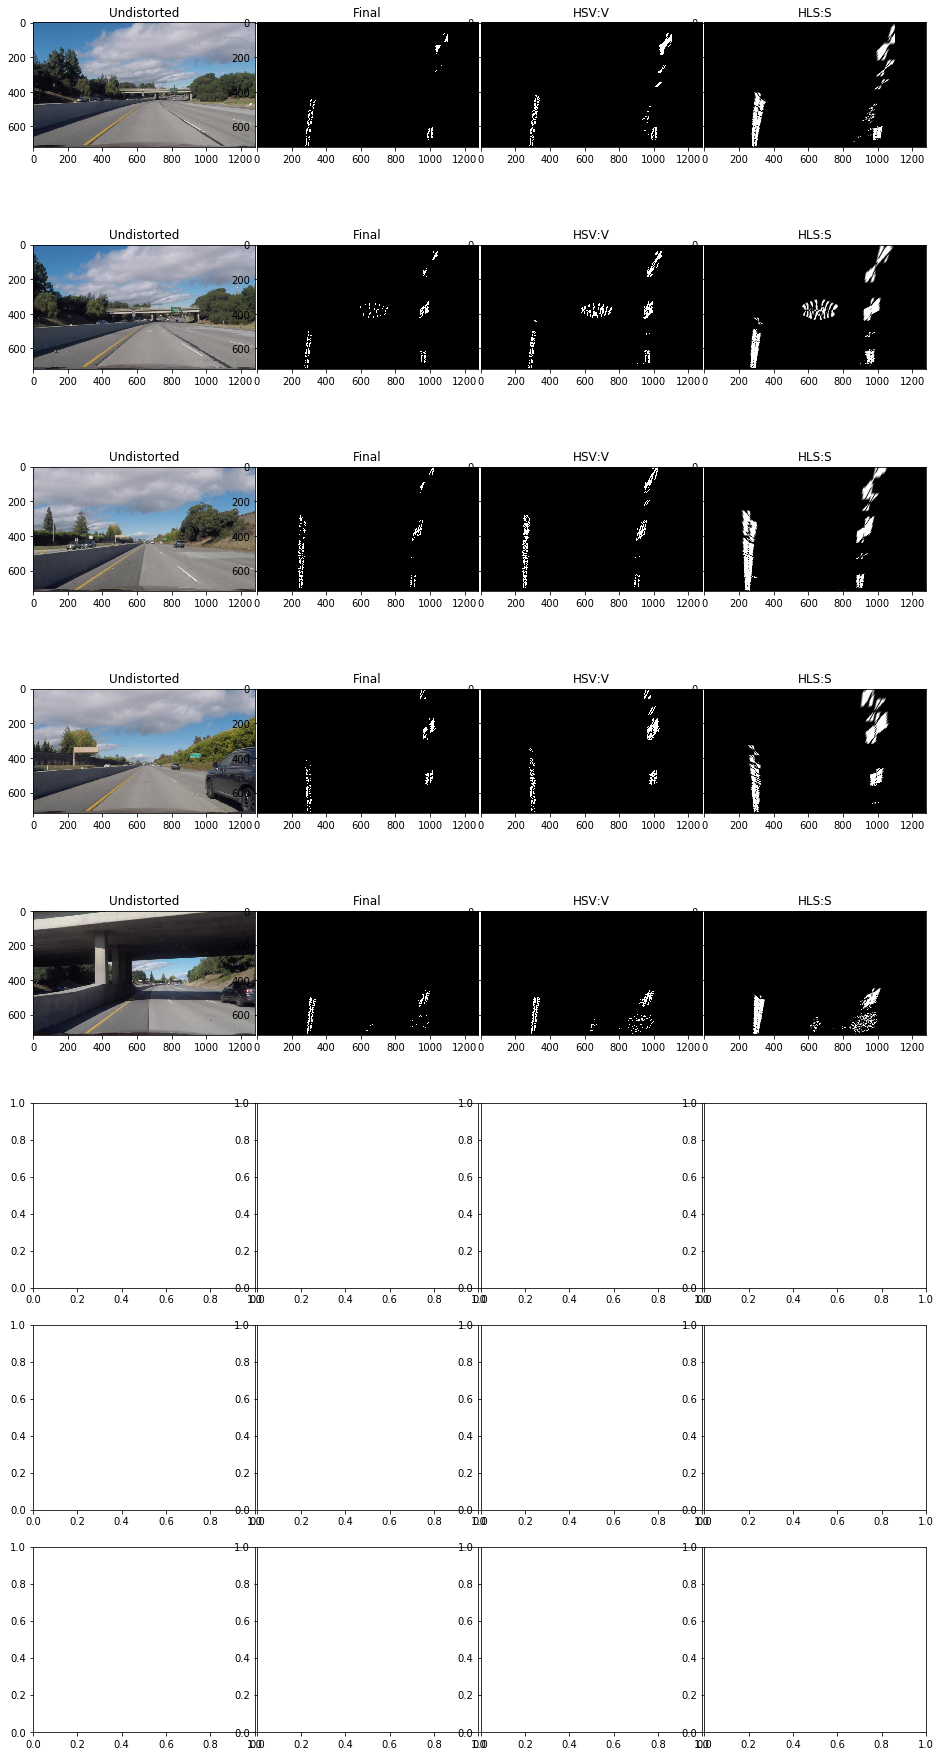

In [292]:
f, axs = plt.subplots(8, 4, figsize=(16,32))
f.subplots_adjust(hspace =.2, wspace=.01)
axs = axs.ravel()

for i,img in enumerate(test_imgs):
    img0, undist, img1, img2 = image_pipeline(img)
    axs[4*i].imshow(undist)
    axs[4*i].set_title('Undistorted')
    axs[4*i+1].imshow(img0,cmap='gray')
    axs[4*i+1].set_title('Final')
    axs[4*i+2].imshow(img1,cmap='gray')
    axs[4*i+2].set_title('HSV:V')
    axs[4*i+3].imshow(img2,cmap='gray')
    axs[4*i+3].set_title('HLS:S')


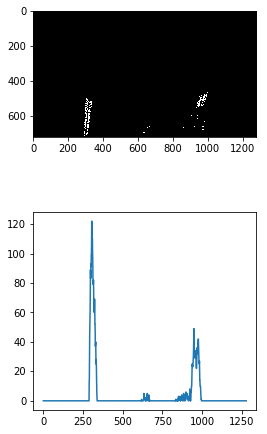

In [293]:
f, axs = plt.subplots(2, 1, figsize=(4,8))
f.subplots_adjust(hspace =.2, wspace=.01)
axs = axs.ravel()
comb, undist, img0,img1= image_pipeline(test_imgs[4])
axs[0].imshow(comb)
yrange = (480,720)
histogram = np.sum(comb[yrange[0]:yrange[1],:], axis=0)
axs[0].imshow(comb, cmap='gray')
axs[1].plot(histogram)

In [294]:

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
def cal_curvature(x, y):
    # Define conversions in x and y from pixels space to meters
    fit_cr = np.polyfit(y*ym_per_pix, x*xm_per_pix, 2)
    curverad = ((1 + (2*fit_cr[0]*np.max(y) + fit_cr[1])**2)**1.5) /np.absolute(2*fit_cr[0])
    return curverad

In [295]:
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50

def full_search_lanes(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    left_max = np.max(histogram[:midpoint])
    if left_max < 50:
        leftx_base = 300
    else:    
        leftx_base = np.argmax(histogram[:midpoint])
        
    right_max = np.max(histogram[:midpoint])
    if right_max < 50:
        rightx_base = 1000
    else:
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    dbg.leftx_base = leftx_base
    dbg.rightx_base = rightx_base
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    left_windows = []
    right_windows = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        left_windows.append(((win_xleft_low,win_y_low),(win_xleft_high,win_y_high)))
        right_windows.append(((win_xright_low,win_y_low),(win_xright_high,win_y_high)))
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
   
    #if lane is not detected, return an empty list for its fit.
    left_fit = []
    right_fit = []
    left_curverad = 0.0
    right_curverad = 0.0
    # Fit a second order polynomial to each
    if leftx is not None and len(leftx)>0:
        left_fit = np.polyfit(lefty, leftx, 2)
        left_curverad = cal_curvature(leftx, lefty)
    if rightx is not None and len(rightx)>0:    
        right_fit = np.polyfit(righty, rightx, 2)
        right_curverad = cal_curvature(rightx, righty)
    
    return left_fit, right_fit, left_curverad, right_curverad, \
           left_windows, right_windows, \
           (leftx, lefty, rightx, righty)
        
def draw_fit_line(img, fit, color):
    if fit is None or len(fit) == 0:
        #not found fit line, do nothing
        return img
    h = img.shape[0]
    ploty = np.linspace(0, h-1, h)
    plotx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    pts = np.int32([np.transpose(np.vstack([plotx, ploty]))])
    cv2.polylines(img, pts, isClosed=False, color=color, thickness=8)
    return img    
def visualize_full_search(mask_img, left_fit, right_fit, left_windows, right_windows, points):
    # Draw the windows on the visualization image
    for w in left_windows:    
        cv2.rectangle(mask_img,w[0], w[1], (0,255,0), 5) 
    for w in right_windows:    
        cv2.rectangle(mask_img,w[0], w[1], (0,255,0), 5) 
        
    if len(points) != 0:
        lx,ly,rx,ry = points
        mask_img[ly, lx] = [255, 0, 0]
        mask_img[ry, rx] = [0, 0, 255]
    draw_fit_line(mask_img, left_fit, (255,255,0))
    draw_fit_line(mask_img, right_fit, (255,255,0))
    return mask_img

2114.66128957 m 5383.26954791 m


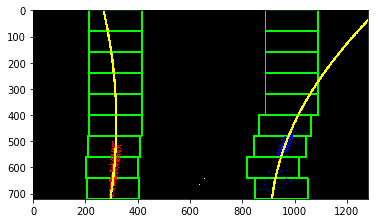

In [301]:
binary_warped, undist, _,_ = image_pipeline(test_imgs[4])

mask_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
left_fit, right_fit, left_curverad, right_curverad, lw, rw, pts = full_search_lanes(binary_warped)
mask_img = visualize_full_search(mask_img,left_fit, right_fit, lw, rw, pts)
plt.imshow(mask_img)
plt.xlim(0, 1280)
plt.ylim(720, 0)
print(left_curverad,'m', right_curverad, 'm')

In [302]:
def update_search_lanes(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_out = []
    right_fit_out = []
    left_curverad = 0.0
    right_curverad = 0.0
    
    if leftx is not None and len(leftx)>0:
        left_fit_out = np.polyfit(lefty, leftx, 2)
        left_curverad = cal_curvature(leftx, lefty)
    if rightx is not None and len(rightx)>0:    
        right_fit_out = np.polyfit(righty, rightx, 2)
        right_curverad = cal_curvature(rightx, righty)
    return left_fit_out, right_fit_out,left_curverad, right_curverad, (leftx, lefty, rightx, righty)

def visualize_update_search(mask_img, left_fit, right_fit, points, draw_margin=True):
    # Generate x and y values for plotting
    # Create an image to draw on and an image to show the selection window
    if len(points) != 0:
        lx,ly,rx,ry = points
        # Color in left and right line pixels
        mask_img[ly, lx] = [255, 0, 0]
        mask_img[ry, rx] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    if draw_margin:
        window_img = np.zeros_like(mask_img)
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        mask_img = cv2.addWeighted(mask_img, 1, window_img, 0.3, 0)
    draw_fit_line(mask_img, left_fit, (255,255,0))
    draw_fit_line(mask_img, right_fit, (255,255,0))
    return mask_img
        

2114.66128957 m 4196.7580822 m


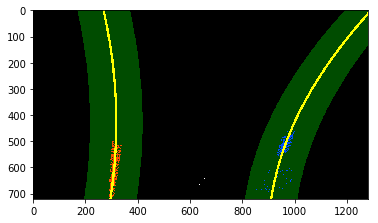

In [303]:
left_fit, right_fit, left_curverad, right_curverad, pts,= update_search_lanes(binary_warped, left_fit, right_fit)
mask_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
img_out = visualize_update_search(mask_img, left_fit, right_fit, pts)
plt.imshow(img_out)
plt.xlim(0, 1280)
plt.ylim(720, 0)
    
print(left_curverad,'m', right_curverad, 'm')

In [299]:
# Create an image to draw the lines on
def poly_fill_lanes(binary_warped, undist, left_fit, right_fit):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    #print (right_fitx[-1] - left_fitx[-1])
    return result

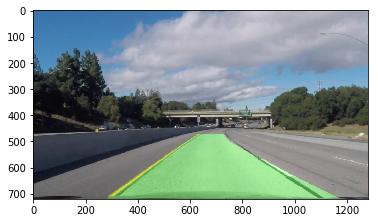

In [300]:
result = poly_fill_lanes(binary_warped, undist, left_fit, right_fit)
plt.imshow(result)

In [286]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = []  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #polynomial coefficients for the most n recent fits
        self.recent_fits = []
        self.recent_curverad = []
        #the latest frame count of successful detection
        self.f_cnt = 0
    def check(self, fit, curverad,n_pts = -1):
        if len(fit) == 0:
            self.detected = False
        else:
            self.detected = True
            if len(self.best_fit)>0:
                #check if current fit is similiar with average fit
                #FIXME: if best_fit is from long time ago, and current fit is resonable
                #  like has a lot n_pts, curverad is reasonable,
                #  Then reset best_fit?
                self.diffs = abs(fit - self.best_fit)
                if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.):
                    dbg.messages.append('current fit is too far away from best_fit.')
                    dbg.messages.append('And found points in windows:{}'.format(n_pts))
                    if (n_pts<10000):
                        self.detected = False
            if not 5.0 <= curverad:
                self.detected = False
            
            
    def update(self, fit, curverad, f_cnt):
        #Only keep 6 most recent fits        
        if len(fit)>0:
            self.current_fit = fit
        if len(self.recent_fits)>6:
            self.recent_fits.pop(0)
            self.recent_curverad.pop(0)
        if self.detected:
            self.recent_fits.append(fit)    
            self.recent_curverad.append(curverad)
            #if len(self.recent_fits)>0:
            self.best_fit = np.average(self.recent_fits, axis=0)
            #if len(self.recent_curverad)>0:    
            self.radius_of_curvature = np.mean(self.recent_curverad)
            self.last_updated = f_cnt
        

In [287]:
def process_image(img):
    '''
    find the left and right line on input image of img, and update l_line and r_line
    '''
    global frame_cnt
    lw = []
    rw = []
    pts =[]
    left_curverad = 0.0
    right_curverad = 0.0
    center_dist = 0.0
    dbg.messages = []
    dbg.messages.append('frame:{}'.format(frame_cnt))
    #if frame_cnt > 32:
    #    return img
    
    
    warped, undist, _, _ = image_pipeline(img)
    l_ck_pass = r_ck_pass = False
    
    if l_line.detected and r_line.detected:
        #if both left and right lane were detected in last frame, we can do an update search
        left_fit, right_fit, left_curverad, right_curverad, pts = \
            update_search_lanes(warped, l_line.best_fit, r_line.best_fit)
        #Check if found lines are valid
        dbg.messages.append('update left:')
        l_line.check(left_fit, left_curverad)
        
        dbg.messages.append('update right:')
        r_line.check(right_fit, right_curverad)
            
    if not l_line.detected or not r_line.detected:
        #if any lane is not detected, either at beginning or lost tracking in the update search,
        #  proceed a fully search
        left_fit, right_fit, left_curverad, right_curverad, lw, rw, pts = full_search_lanes(warped)
        dbg.messages.append('fully search left:')
        l_line.check(left_fit, left_curverad, len(pts[0]))
        
        dbg.messages.append('fully search right:')
        r_line.check(right_fit, right_curverad, len(pts[2]))
    #cross checking    
    if l_line.detected and r_line.detected:
        
        #check if the left and right curverad are similiar if they are not very big
        if abs(right_curverad - left_curverad) > 500.0 and \
            right_curverad < 1000.0 and \
            left_curverad < 1000.0:
                dbg.messages.append('Curvature checking failed. left:{} right:{}\n'.format(right_curverad,left_curverad))
                l_line.detected = False
                r_line.detected = False
        #the most left x, the left x to car center         
        y = img.shape[0]
        x_msl = left_fit[0]*y**2 + left_fit[1]*y + left_fit[2]  
        x_msr = right_fit[0]*y**2 + right_fit[1]*y + right_fit[2]  
        
        if x_msl < 150 or x_msl > 640:
            l_line.detected = False
        if x_msr < 640 or x_msl > 1200:
            r_line.detected = False
            
        #check if the line width is not reasonable
        if (x_msr - x_msl) < 550 or (x_msr - x_msl)>850:
            dbg.messages.append('Lane distance checking failed. left:{} right:{}\n'.format(x_msl,x_msr))
            l_line.detected = False
            r_line.detected = False
        #FIXME: do we need to smooth the center_dist? 
        lane_center_position = (x_msl + x_msr)/2
        center_dist = (img.shape[1]/2 - lane_center_position) * xm_per_pix
        
    l_line.update(left_fit, left_curverad, frame_cnt)    
    r_line.update(right_fit, right_curverad, frame_cnt)    
    #Overlay the lane detection mask
    out_img = poly_fill_lanes(warped, undist, l_line.best_fit, r_line.best_fit)
    info = []
    info.append( "Curvature: left:{:8.2f} right:{:8.2f}".format(left_curverad, right_curverad))
    info.append("Detected Lane Center offset from center:{:8.2f}".format(center_dist))
    for i, text in enumerate(info):
        cv2.putText(out_img, text, (20,50+i*30), cv2.FONT_HERSHEY_COMPLEX, 1.0, (255,255,255), 1, cv2.LINE_AA)
    
    diagnostic_output = True
    if diagnostic_output:
        # put together multi-view output
        diag_img = np.zeros((720,1280,3), dtype=np.uint8)
        
        # original output (top left)
        diag_img[0:360,0:640,:] = cv2.resize(out_img,(640,360))
        
        
        # overhead with all fits added (bottom right)
        img_bin_fit = np.dstack((warped*255, warped*255, warped*255))
        for i, fit in enumerate(l_line.recent_fits):
            img_bin_fit = draw_fit_line(img_bin_fit, fit, (20*i+100,0,20*i+100))
        for i, fit in enumerate(r_line.recent_fits):
            img_bin_fit = draw_fit_line(img_bin_fit, fit, (20*i+100,0,20*i+100))
        img_bin_fit = draw_fit_line(img_bin_fit, l_line.current_fit, (128,255,0)) 
        img_bin_fit = draw_fit_line(img_bin_fit, r_line.current_fit, (128,255,0))
        img_bin_fit = visualize_full_search(img_bin_fit, l_line.best_fit, r_line.best_fit, lw, rw, [])
        diag_img[0:360,640:1280, :] = cv2.resize(img_bin_fit, (640, 360))
        
        #diag_img[360:720,640:1280,:] = cv2.resize(img_bin_fit,(640,360))
        for i, msg in enumerate(dbg.messages):
            cv2.putText(diag_img, msg, (20,400+i*40), cv2.FONT_HERSHEY_COMPLEX, 1.0, (255,255,255), 1, cv2.LINE_AA)
        
        out_img = diag_img
        frame_cnt += 1
    return out_img
    
    
    #debug
        

In [288]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
l_line = Line()
r_line = Line()
frame_cnt = 0
output_video = 'challenge_output.mp4'
clip1 = VideoFileClip("challenge_video.mp4")
out = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video challenge_output.mp4
[MoviePy] Writing video challenge_output.mp4



 64%|██████▎   | 309/485 [00:54<00:30,  5.77it/s]


100%|██████████| 485/485 [01:24<00:00,  5.93it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_output.mp4 

CPU times: user 3min 28s, sys: 844 ms, total: 3min 29s
Wall time: 1min 25s


In [304]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
l_line = Line()
r_line = Line()
frame_cnt = 0
output_video = 'harder_challenge_output.mp4'
clip1 = VideoFileClip("harder_challenge_video.mp4")
out = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out.write_videofile(output_video, audio=False)

[MoviePy] >>>> Building video harder_challenge_output.mp4
[MoviePy] Writing video harder_challenge_output.mp4



 25%|██▌       | 303/1200 [00:52<02:25,  6.16it/s]


 50%|█████     | 605/1200 [01:44<01:33,  6.37it/s]


 76%|███████▌  | 907/1200 [02:36<00:50,  5.76it/s]


100%|█████████▉| 1199/1200 [03:28<00:00,  5.45it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: harder_challenge_output.mp4 

CPU times: user 8min 44s, sys: 1.83 s, total: 8min 46s
Wall time: 3min 29s


In [2]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
l_line = Line()
r_line = Line()
frame_cnt = 0
output_video = 'project_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
out = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time out.write_videofile(output_video, audio=False)

NameError: name 'Line' is not defined

In [289]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
# Set up lines for left and right
clip1 = VideoFileClip("challenge_video.mp4")
clip1.save_frame('./challenge/4.jpg', t="0:0:4")